In [1]:
import os
import sys
import json
from datetime import datetime
from argparse import ArgumentParser
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
sys.path.append(os.path.join(os.getcwd(), 'learning_algorithms'))

from distributional_cb import DistributionalCB
from cost_functions import constrained_loss, critic_objective
# from env_syn import EnvSyn
from env_tank import EnvTank
from utils_learning import OUNoise

In [2]:
np.floor(datetime.now().timestamp()).astype(int)

1747863144

In [2]:
def main():
    
    algo = 'MC_DNCB'
    updates_per_step = 5
    timestamp = str(np.floor(datetime.now().timestamp()).astype(int))
    tag = '' # kill?
    batch_size = 64
    train_iters = 20000
    eval_iters = 500
    env_noise_var = [1e-4, 1e-4]
    env_version = 2
    landa = None # kill?
    quantile_critic =\
            [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.99, 0.995, 0.999]
    A_exec = None # kill?
    A_train = None # kill?
    A_explo = None # kill?
    alpha_all = None # kill? [A_exec, A_train, A_explo]
    constr_val = None

    tag = '_'+tag if len(tag)>0 else tag
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f'torch device: {device}')
    
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S") if timestamp=='' else timestamp
    
    # cnn_kwargs = None
    # cnn_kwargs = {'in_features' : 1, 'num_cells' : [32, 8, 2], 'kernel_sizes' : 5}
    # cnn_kwargs = {'in_features' : 1, 'num_cells' : [1], 'kernel_sizes' : 7, 'norm_class' : nn.MaxPool3d, 'norm_kwargs' : {'kernel_size' : 2, 'stride' : 2}}
    NN_arch = [256, 256]
    distrib_critic = 0
    
    
    if algo == 'MC_DNCB':
        critic_kwargs_1 = {'num_cells' : NN_arch, 'activation_class' : nn.ReLU, 'n_quantiles' : 21, 'quantile_vals' : None}
        critic_kwargs_2 = {'num_cells' : NN_arch, 'activation_class' : nn.ReLU, 'n_quantiles' : 21, 'quantile_vals' : None}
        critics_kwargs = [critic_kwargs_1]
        if env_version == 2:
            critics_kwargs.append(critic_kwargs_2)
        critic_loss = 'quantile_huber_loss'
        distrib_critic = 1
        
    else:
        raise Exception('Unknown algorithm')
    
    actor_kwargs = {'num_cells' : [256, 256], 'activation_class' : nn.ReLU, 'last_activation' : nn.Sigmoid}
    
    noise = OUNoise(1, decay_period=train_iters*2/3)
    env_noise = {'dist' : 'norm', 'var' : env_noise_var}
    
    contexts_file = ''
    env = EnvTank(algo=algo+'_train'+tag, noise=env_noise, timestamp=timestamp, contexts_file=contexts_file, ver=env_version)
    
    
    actor_loss = constrained_loss(distrib_critic, quantile_critic, constr_op='max', device=device)
    critic_objective_class = critic_objective(n_critics=len(critics_kwargs), constr_op='max', device=device)
    alpha_input_actor = 0
    
    
    ######## Save config data ########
    config_file = os.path.join(os.getcwd(), 'results', timestamp, timestamp+f'_{algo+tag}_config.json')
    
    config_data = {'algorithm' : algo, 'updates_per_step' : updates_per_step, 'train_iters' : train_iters, 
                   'eval_iters' : eval_iters, 'timestamp' : timestamp, 'env_noise' : str(env_noise), 
                   'landa' : landa, 'quantile_critic' : quantile_critic, 'critic_loss' : critic_loss, 
                   'critic_objective_class' : str(critic_objective_class), 'actor_loss' : str(actor_loss), 
                   'alpha_input_actor' : alpha_input_actor, 'device' : str(device), 
                   'actor_kwargs' : str(actor_kwargs), 'critics_kwargs' : str(critics_kwargs), 
                   'exploration_noise' : str(type(noise)) }
    with open(config_file, 'w') as f:
        json.dump(config_data, f, indent=4)
    ################################
    
    distrib_cb = DistributionalCB(env, noise, batch_size, actor_kwargs=actor_kwargs, critics_kwargs=critics_kwargs, actor_loss_function=actor_loss, 
                                  critic_loss=critic_loss, critic_objective_class=critic_objective_class, updates_per_step=updates_per_step, device=device)
    
    
    distrib_cb.run(train_iters)
    distrib_cb.env.close()
    
    contexts_file_eval = ''
    env_eval = EnvTank(algo=algo+tag, noise=env_noise, timestamp=timestamp, contexts_file=contexts_file_eval, ver=env_version)
    distrib_cb.env = env_eval
    
    # for alpha_exec in A_exec:
        # distrib_cb.run(eval_iters, evaluation=1, alpha_exec=alpha_exec)
    distrib_cb.run(eval_iters, evaluation=1)
    distrib_cb.close()

    


In [3]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
os.environ["PYTHONHASHSEED"] = str(seed)

main()

torch device: cuda:0
MLP(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)
MLP(
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=21, bias=True)
)
MLP(
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=21, bias=True)
)
Step 100 / 20000
Step 200 / 20000
Step 300 / 20000
Step 400 / 20000
Step 500 / 20000
Step 600 / 20000
Step 700 / 20000
Step 800 / 20000
Step 900 / 20000
Step 1000 / 20000
Step 1100 / 20000
Step 1200 / 20000
Step 1300 / 20000
Step 1400 / 20000
Step 1500 / 20000
Step 1600 / 20000
Step 1700 / 20000
Step 1800 / 20000
Step 1900 / 

/home/clementejasonfortuna/anaconda3/envs/pytorch113/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Step 5800 / 20000
Step 5900 / 20000
Step 6000 / 20000
Step 6100 / 20000
Step 6200 / 20000
Step 6300 / 20000
Step 6400 / 20000
Step 6500 / 20000
Step 6600 / 20000
Step 6700 / 20000
Step 6800 / 20000
Step 6900 / 20000
Step 7000 / 20000
Step 7100 / 20000
Step 7200 / 20000
Step 7300 / 20000
Step 7400 / 20000
Step 7500 / 20000
Step 7600 / 20000
Step 7700 / 20000
Step 7800 / 20000
Step 7900 / 20000
Step 8000 / 20000
Step 8100 / 20000
Step 8200 / 20000
Step 8300 / 20000
Step 8400 / 20000
Step 8500 / 20000
Step 8600 / 20000
Step 8700 / 20000
Step 8800 / 20000
Step 8900 / 20000
Step 9000 / 20000
Step 9100 / 20000
Step 9200 / 20000
Step 9300 / 20000
Step 9400 / 20000
Step 9500 / 20000
Step 9600 / 20000
Step 9700 / 20000
Step 9800 / 20000
Step 9900 / 20000
Step 10000 / 20000
Step 10100 / 20000
Step 10200 / 20000
Step 10300 / 20000
Step 10400 / 20000
Step 10500 / 20000
Step 10600 / 20000
Step 10700 / 20000
Step 10800 / 20000
Step 10900 / 20000
Step 11000 / 20000
Step 11100 / 20000
Step 11200 / 200

In [4]:
datadir = os.getcwd() + '/results/1752011025'
testdatpth = datadir + '/1752011025_MC_DNCB_log.csv'

test_df = pd.read_csv(testdatpth)
test_df = test_df.drop(index = 0)
test_df['context'].str[1:-1].str.split(' +', expand=True)[0]
test_df['shooter_pos'] = test_df['context'].str[1:-1].str.split(' +', expand=True)[0]
test_df['target_pos'] = test_df['context'].str[1:-1].str.split(' +', expand=True)[1]
test_df['el'] = np.rad2deg(test_df['action'].str[1:-1].astype(float))
test_df = test_df.drop(columns=['context', 'action', 'alpha'])
test_df['norm_miss'] = np.power(test_df['reward1'], 4) / 10
test_df

,step,reward1,reward2,shooter_pos,target_pos,el,norm_miss
1,1,0.356952,2.214924,-25579.607,27046.838,15.513011,0.001623
2,2,0.455712,3.318875,-7313.5776,28025.752,10.096485,0.004313
3,3,0.389482,2.604076,-15501.322,34266.258,14.574946,0.002301
4,4,0.327777,1.907083,-42623.42,14758.524,17.106351,0.001154
5,5,0.310960,1.638883,,3060.2214,13.700885,0.000935
...,...,...,...,...,...,...,...
494,494,0.370983,2.488466,-33333.145,28702.459,18.701483,0.001894
495,495,0.534207,3.857416,-18919.875,-6481.444,3.475690,0.008144
496,496,0.375540,2.219208,-42484.637,-9944.267,9.327077,0.001989
497,497,0.544880,4.219865,28358.404,46147.08,4.980194,0.008815


array([[<Axes: title={'center': 'el'}>]], dtype=object)

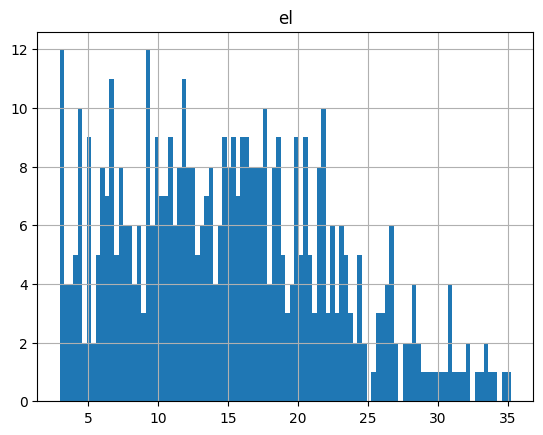

In [5]:
test_df.hist(column = 'el', bins = 100)

array([[<Axes: title={'center': 'norm_miss'}>]], dtype=object)

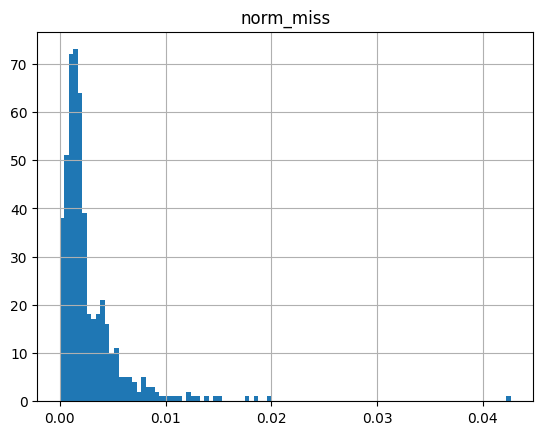

In [6]:
test_df.hist(column = 'norm_miss', bins = 100)